# Kinship analysis using KING and PCRelate

In [4]:
library(SNPRelate) |> suppressPackageStartupMessages()
library(GWASTools) |> suppressPackageStartupMessages()
library(GENESIS) |> suppressPackageStartupMessages()
library(ggplot2) |> suppressPackageStartupMessages()
library(dplyr) |> suppressPackageStartupMessages()
library(SeqVarTools) |> suppressPackageStartupMessages()
showfile.gds(closeall=TRUE)

In [5]:
vcf_file <- "../inputfiles/bft.thinned.vcf.gz"
gds_file <- "../inputfiles/bft.thinned.gds"

## VCF to GDS format
The `Bioconductor` suite of packages require their own proprietary format, so first a conversion is required

In [ ]:
SNPRelate::snpgdsVCF2GDS(
    vcf.fn = vcf_file, 
    out.fn = gds_file,
    method = 'biallelic.only',
    verbose = F
)

Open the GDS file

In [7]:
gdsobj <- snpgdsOpen(gds_file)

## KING-Robust analysis

IBD analysis (KING method of moment) on genotypes:
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 334
    # of SNPs: 1,470
    using 1 thread
No family is specified, and all individuals are treated as singletons.
Relationship inference in the presence of population stratification.
KING IBD:    the sum of all selected genotypes (0,1,2) = 883704
CPU capabilities: Double-Precision SSE2
Tue Jul 19 10:49:25 2022    (internal increment: 65536)
[==================================================] 100%, completed, 0s  
Tue Jul 19 10:49:25 2022    Done.


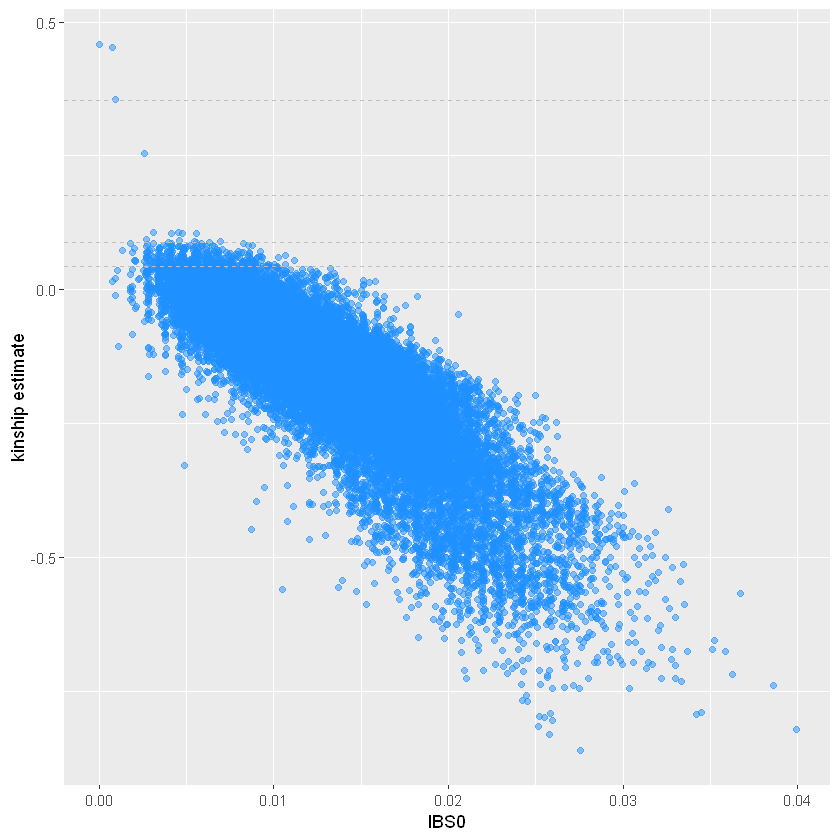

In [8]:
king <- snpgdsIBDKING(gdsobj, autosome.only = FALSE)
kingMat <- king$kinship
colnames(kingMat) <- rownames(kingMat) <- king$sample.id
kinship <- snpgdsIBDSelection(king)

ggplot(kinship, aes(IBS0, kinship)) +
    geom_point(alpha=0.5, color = "dodgerblue") +
    geom_hline(yintercept=2^(-seq(3,9,2)/2), linetype="dashed", color="grey") +
    ylab("kinship estimate")

## PC-AIR Analysis
Based on KING values

In [10]:
sampset <- pcairPartition(
    kinobj=kingMat, kin.thresh=2^(-9/2),
    divobj=kingMat, div.thresh=-2^(-9/2)
)

Using kinobj and divobj to partition samples into unrelated and related sets

Working with 334 samples

Identifying relatives for each sample using kinship threshold 0.0441941738241592

Identifying pairs of divergent samples using divergence threshold -0.0441941738241592

Partitioning samples into unrelated and related sets...



PCA on unrelated individuals

In [11]:
pca.unrel <- snpgdsPCA(gdsobj, sample.id=sampset$unrels, autosome.only = FALSE)


Principal Component Analysis (PCA) on genotypes:
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 268
    # of SNPs: 1,470
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 714043
CPU capabilities: Double-Precision SSE2
Tue Jul 19 10:51:09 2022    (internal increment: 15388)
[==================================================] 100%, completed, 0s  
Tue Jul 19 10:51:09 2022    Begin (eigenvalues and eigenvectors)
Tue Jul 19 10:51:09 2022    Done.


Project values for relatives

In [12]:
snp.load <- snpgdsPCASNPLoading(pca.unrel, gdsobj=gdsobj)
samp.load <- snpgdsPCASampLoading(snp.load, gdsobj=gdsobj, sample.id=sampset$rels)

SNP Loading:
    # of samples: 268
    # of SNPs: 1,470
    using 1 thread
    using the top 32 eigenvectors
SNP Loading:    the sum of all selected genotypes (0,1,2) = 714043
Tue Jul 19 10:51:20 2022    (internal increment: 65536)
[==================================================] 100%, completed, 0s  
Tue Jul 19 10:51:20 2022    Done.
Sample Loading:
    # of samples: 66
    # of SNPs: 1,470
    using 1 thread
    using the top 32 eigenvectors
Sample Loading:    the sum of all selected genotypes (0,1,2) = 169661
Tue Jul 19 10:51:20 2022    (internal increment: 65536)
[==================================================] 100%, completed, 0s  
Tue Jul 19 10:51:20 2022    Done.


Combine unrelated and related PCs and order as in GDS file

In [13]:
pcs <- rbind(pca.unrel$eigenvect, samp.load$eigenvect)
rownames(pcs) <- c(pca.unrel$sample.id, samp.load$sample.id)
sample.id <- rownames(kingMat)
samp.ord <- match(sample.id, rownames(pcs))
pcs <- pcs[samp.ord,]

Add population information

In [17]:
annot <- read.csv("../inputfiles/bft.strata", header = TRUE)[,c(1,6)]
names(annot) <- c("sample.id", "population")
pc.df <- as.data.frame(pcs)
names(pc.df) <- 1:ncol(pcs)
pc.df$sample.id <- row.names(pcs)
pc.df <- left_join(pc.df, annot, by="sample.id")
head(pc.df)

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,sample.id,population
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,-0.006230181,0.011538621,0.003034207,-0.02027414,0.071516168,-0.023423439,-0.015590920,-0.011067387,0.014948815,0.02927265,...,-0.046367511,-0.064976119,-0.109353738,-0.004089156,0.09656424,0.012861873,0.022071348,-0.060845580,BRZ_1261,BRZ
2,-0.026447438,-0.008611402,-0.073949079,0.14288146,0.049282284,0.038621446,0.070497236,-0.057073888,-0.102407746,-0.01211894,...,-0.122468779,0.052631819,0.093921357,0.028141318,0.06080645,0.008165238,0.007870584,-0.020724432,BRZ_1269,BRZ
3,-0.008739515,0.012977460,-0.001519025,0.01090856,0.001802854,0.005754989,0.008360564,0.009821515,0.014439770,0.01141338,...,-0.002367566,0.003508367,-0.001200922,0.040301817,0.02052510,0.003503272,-0.038255833,-0.011150303,BRZ_1270,BRZ
4,-0.003964045,0.008666973,-0.033945919,0.02126315,-0.049522381,0.009949592,0.004079335,-0.064844094,0.002531638,0.01913249,...,-0.068487815,-0.044812899,-0.027691603,0.003065540,0.11617528,-0.019781358,-0.061539153,-0.002966392,BRZ_1271,BRZ
5,-0.014705856,0.022411953,-0.020687119,0.05670356,0.040604709,-0.002902615,0.008067954,0.044141024,0.047899841,0.04472602,...,-0.055766493,0.003941219,0.002666925,-0.031041370,-0.05875448,0.075693712,0.083750472,-0.137434185,BRZ_1275,BRZ
6,-0.008170917,0.027257713,-0.008922920,-0.06729383,-0.016690171,0.013707296,0.025330139,-0.039421772,-0.011348757,0.04552579,...,0.002681921,0.103449451,-0.035000591,-0.053723960,-0.05944906,-0.016991375,-0.056887200,-0.015132839,BRZ_1276,BRZ


Examine the parallel coordinates

In [19]:
library(GGally)
library(RColorBrewer)

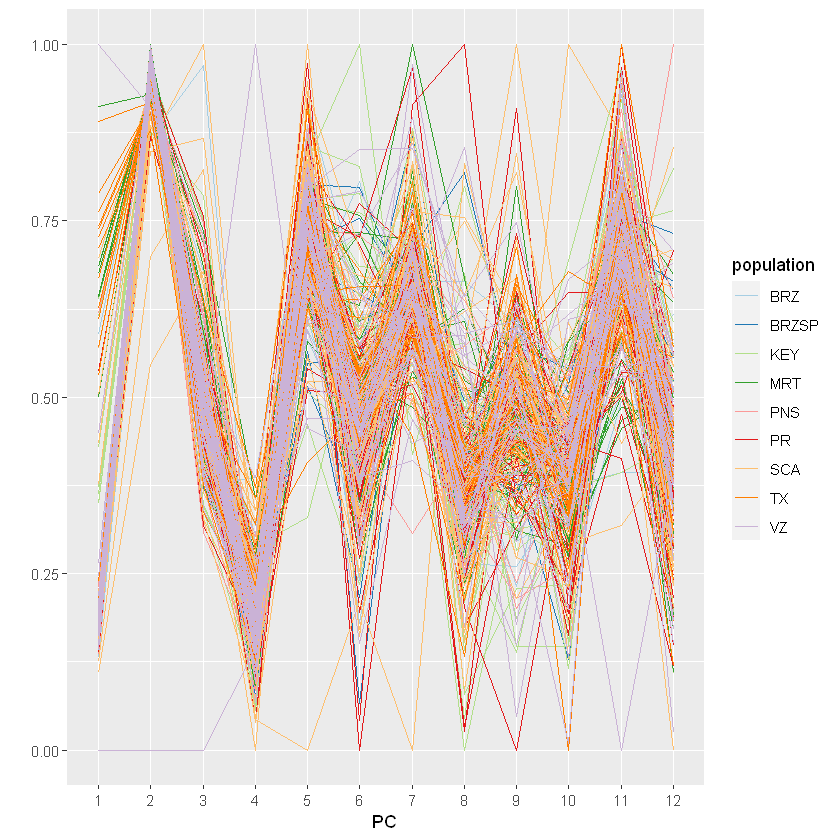

In [20]:
popn <- length(unique(annot$population))
pop.cols <- RColorBrewer::brewer.pal(n = 4, name = "Set2")
pop.cols <- setNames(brewer.pal(popn, "Paired"), unique(annot$population))
ggparcoord(pc.df, columns=1:12, groupColumn="population", scale="uniminmax") +
    scale_color_manual(values=pop.cols) +
    xlab("PC") + ylab("")

## PCRelate

First, close the GDS connection to re-read it as a different format

In [22]:
showfile.gds(closeall=TRUE)
geno <- GdsGenotypeReader(filename = gds_file)
genodata <- GenotypeData(geno)
genodata <- GenotypeBlockIterator(genodata)

In [23]:
pcrel <- pcrelate(
    genodata, 
    pcs = pcs[,1:7], 
    training.set = sampset$unrels, 
    sample.include = sample.id
)

pcrelMat <- pcrelateToMatrix(pcrel, scaleKin = 1)

pca <- pcair(
    genodata,
    kinobj=pcrelMat, kin.thresh = 2^(-9/2),
    divobj=kingMat, div.thresh = -2^(-9/2),
    sample.include = sample.id, 
    autosome.only = FALSE
)


Using 10 CPU cores

334 samples to be included in the analysis...

Betas for 7 PC(s) will be calculated using 268 samples in training.set...

Running PC-Relate analysis for 334 samples using 1470 SNPs in 1 blocks...

Performing Small Sample Correction...

Using 334 samples provided

Identifying clusters of relatives...

    334 relatives in 1 clusters; largest cluster = 334

Creating block matrices for clusters...

0 samples with no relatives included

Using kinobj and divobj to partition samples into unrelated and related sets

Working with 334 samples

Identifying relatives for each sample using kinship threshold 0.0441941738241592

Identifying pairs of divergent samples using divergence threshold -0.0441941738241592

Partitioning samples into unrelated and related sets...

Unrelated Set: 32 Samples 
Related Set: 302 Samples

Performing PCA on the Unrelated Set...



Principal Component Analysis (PCA) on genotypes:
Excluding 385 SNPs (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 32
    # of SNPs: 1,085
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 62744
CPU capabilities: Double-Precision SSE2
Tue Jul 19 11:02:51 2022    (internal increment: 128896)
[==================================================] 100%, completed, 0s  
Tue Jul 19 11:02:51 2022    Begin (eigenvalues and eigenvectors)
Tue Jul 19 11:02:51 2022    Done.


Predicting PC Values for the Related Set...



SNP Loading:
    # of samples: 32
    # of SNPs: 1,085
    using 1 thread
    using the top 32 eigenvectors
SNP Loading:    the sum of all selected genotypes (0,1,2) = 62744
Tue Jul 19 11:02:51 2022    (internal increment: 65536)
[==================================================] 100%, completed, 0s  
Tue Jul 19 11:02:51 2022    Done.
Sample Loading:
    # of samples: 302
    # of SNPs: 1,085
    using 1 thread
    using the top 32 eigenvectors


Warning message in sqrt(ss/loadobj$eigenval[1:eigcnt]):
"NaNs produced"


Sample Loading:    the sum of all selected genotypes (0,1,2) = 579615
Tue Jul 19 11:02:51 2022    (internal increment: 65536)
[==================================================] 100%, completed, 0s  
Tue Jul 19 11:02:51 2022    Done.


In [24]:
pcs <- pca$vectors
pc.df <- as.data.frame(pcs)
names(pc.df) <- paste0("PC", 1:ncol(pcs))
pc.df$sample.id <- row.names(pcs)
pc.df <- left_join(pc.df, annot, by="sample.id")

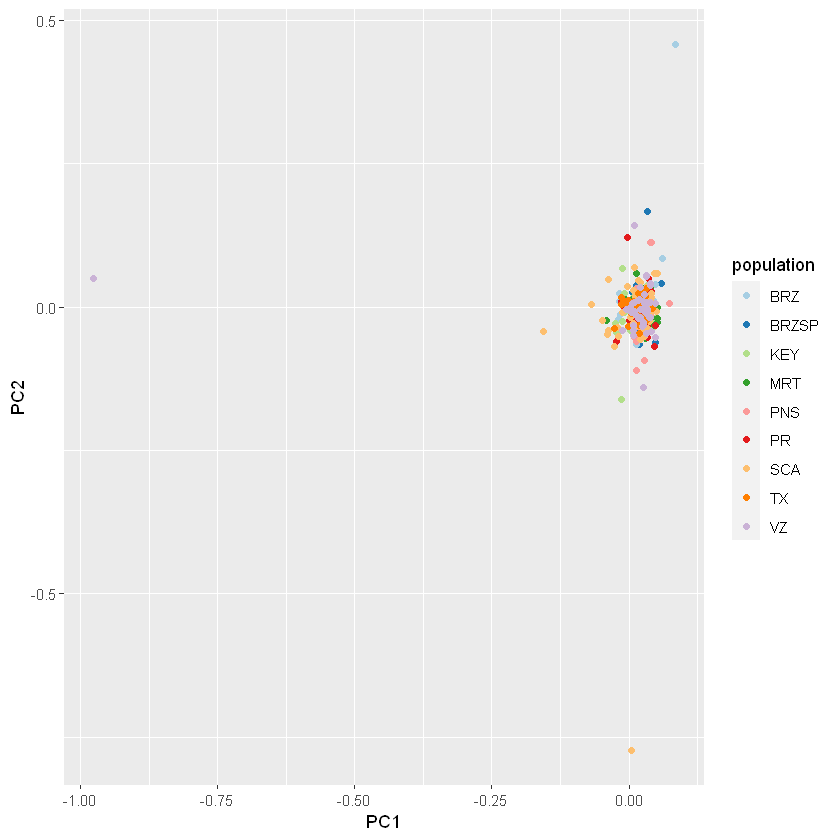

In [25]:
ggplot(pc.df, aes(PC1, PC2, color=population)) + geom_point() +
    scale_color_manual(values=pop.cols)

## Perform the PCRelate analysis again

In [26]:
pcrel <- pcrelate(
    genodata, pcs = pcs[,1:7], 
    training.set = pca$unrels, 
    sample.include = sample.id
)

kinship <- pcrel$kinBtwn

pcrelate_filter <- kinship %>% 
    mutate(
        relationship = case_when(
            (kin <= 0.1767) ~ "unrelated",
            (kin >=0.1767 & kin < 0.3535) ~ "halfsib",
            (kin >= 0.3535) ~ "fullsib"
        )
    )

Using 10 CPU cores

334 samples to be included in the analysis...

Betas for 7 PC(s) will be calculated using 32 samples in training.set...

Running PC-Relate analysis for 334 samples using 1470 SNPs in 1 blocks...

Performing Small Sample Correction...



In [27]:
write.table(pcrelate_filter, file = "pcrelate.out", row.names = F, quote = F)

## Plot the results

In [32]:
mycolors <- c("#8a556e", "#bbbbbb")

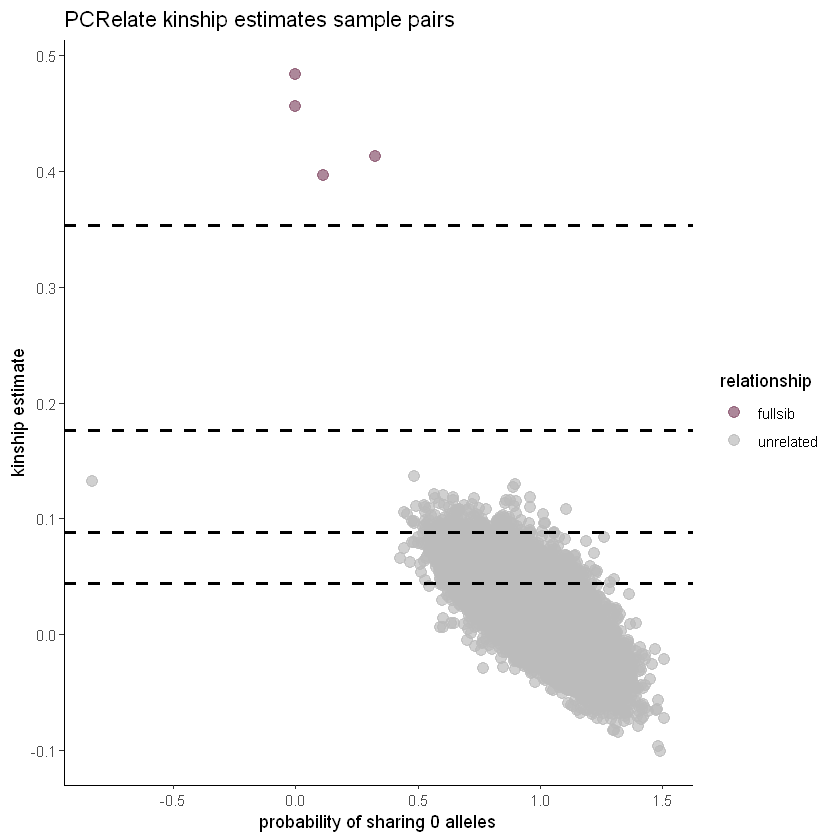

In [41]:
ggplot(pcrelate_filter, aes(k0, kin)) +
    geom_point(alpha=0.7, size = 3, aes(color = relationship)) +
    geom_hline(yintercept=2^(-seq(3,9,2)/2), linetype="dashed", color="black", size = 1) +
    scale_color_manual(values = mycolors) +
    labs(title = "PCRelate kinship estimates sample pairs") +
    ylab("kinship estimate") +
    xlab("probability of sharing 0 alleles") +
    theme_classic()

In [42]:
ggsave("pcrelate.kinship.png")

Saving 6.67 x 6.67 in image



In [46]:
kintable <- pcrelate_filter %>% 
    filter(relationship != "unrelated") %>% 
    arrange(desc(kin))
kintable$perc_identical <- c(99, 99, 94, 96)
kintable$adjacent_wells <- c(T, T, T, F)
kintable

ID1,ID2,kin,k0,k2,nsnp,relationship,perc_identical,adjacent_wells
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
KEY_1381,KEY_1382,0.4842287,0.0000000,0.8301193,643,fullsib,99,TRUE
TX_1113,TX_1114,0.4559795,0.0000000,1.0496195,887,fullsib,99,TRUE
TX_1121,TX_1122,0.4134949,0.3252175,0.8050111,818,fullsib,94,TRUE
PR_1063,PR_967,0.3969223,0.1142326,0.9391187,696,fullsib,96,FALSE


In [47]:
write.table(kintable, file = "pcrelate.kin", row.names = FALSE, quote = FALSE)